# 01: Data Exploration

This notebook explores the LMSYS dataset structure and computes initial descriptive statistics.

## Goals
1. Load and understand the dataset structure
2. Examine conversation patterns
3. Understand user behavior and return patterns
4. Identify potential confounders for causal analysis

In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root / 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 50)

%matplotlib inline
sns.set_style('whitegrid')

## 1. Load the Dataset

In [2]:
from quant_syco.data.download import download_lmsys

df_raw = download_lmsys()
print(f"Dataset shape: {df_raw.shape}")
print(f"\nColumns: {list(df_raw.columns)}")

Loading cached data from /Users/nijjohnson/Projects/quant-sycophantic/data/raw/lmsys_raw.parquet

Dataset shape: (33000, 13)

Columns: ['question_id', 'model_a', 'model_b', 'winner', 'judge', 'conversation_a', 'conversation_b', 'turn', 'anony', 'language', 'tstamp', 'openai_moderation', 'toxic_chat_tag']


In [3]:
df_raw.head(2)

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,turn,anony,language,tstamp,openai_moderation,toxic_chat_tag
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,"[{'content': 'What is the difference between OpenCL and CUDA?', 'role': 'user'}, {'content': 'Op...","[{'content': 'What is the difference between OpenCL and CUDA?', 'role': 'user'}, {'content': 'Op...",1,True,English,1.682352e+09,"{'categories': {'harassment': False, 'harassment/threatening': False, 'hate': False, 'hate/threa...","{'roberta-large': {'flagged': False, 'probability': 0.008313022553920746}, 't5-large': {'flagged..."
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,"[{'content': 'Why did my parent not invite me to their wedding?', 'role': 'user'}, {'content': '...","[{'content': 'Why did my parent not invite me to their wedding?', 'role': 'user'}, {'content': '...",1,True,English,1.682352e+09,"{'categories': {'harassment': False, 'harassment/threatening': False, 'hate': False, 'hate/threa...","{'roberta-large': {'flagged': False, 'probability': 0.03876686096191406}, 't5-large': {'flagged'..."


## 2. Build Battle Table

In [4]:
from quant_syco.data.process import build_battle_table

battles = build_battle_table(df_raw)
print(f"Battle table shape: {battles.shape}")
battles.head(2)

Processing 33,000 battles...

Built battle table with 33,000 rows

Columns: ['question_id', 'user_id', 'judge', 'ts_utc', 'model_a', 'model_b', 'winner', 'language', 'user_prompt', 
'assistant_a', 'assistant_b', 'turn', 'anony', 'openai_moderation', 'toxic_chat_tag']

Battle table shape: (33000, 15)


,question_id,user_id,judge,ts_utc,model_a,model_b,winner,language,user_prompt,assistant_a,assistant_b,turn,anony,openai_moderation,toxic_chat_tag
0,58210e39b3fd4441a2bd4a518bb44c2d,arena_user_973,arena_user_973,2023-04-24 15:53:11.132200003+00:00,chatglm-6b,koala-13b,model_b,English,What is the difference between OpenCL and CUDA?,OpenCL and CUDA are two different programming models that are used for parallel computing.OpenCL...,"OpenCL and CUDA are both programming languages for parallel computing on GPUs, but they differ i...",1,True,"{'categories': {'harassment': False, 'harassment/threatening': False, 'hate': False, 'hate/threa...","{'roberta-large': {'flagged': False, 'probability': 0.008313022553920746}, 't5-large': {'flagged..."
1,2564acd09e3942fd97657d05282d4389,arena_user_973,arena_user_973,2023-04-24 15:54:14.674700022+00:00,oasst-pythia-12b,alpaca-13b,tie,English,Why did my parent not invite me to their wedding?,It is possible that your parent did not invite you to their wedding for a variety of reasons. It...,It is likely that they wanted to keep the guest list small and intimate. Maybe they felt that in...,1,True,"{'categories': {'harassment': False, 'harassment/threatening': False, 'hate': False, 'hate/threa...","{'roberta-large': {'flagged': False, 'probability': 0.03876686096191406}, 't5-large': {'flagged'..."


## 3. Winner Distribution

winner
model_a          11744
model_b          11550
tie (bothbad)     6263
tie               3443
Name: count, dtype: int64


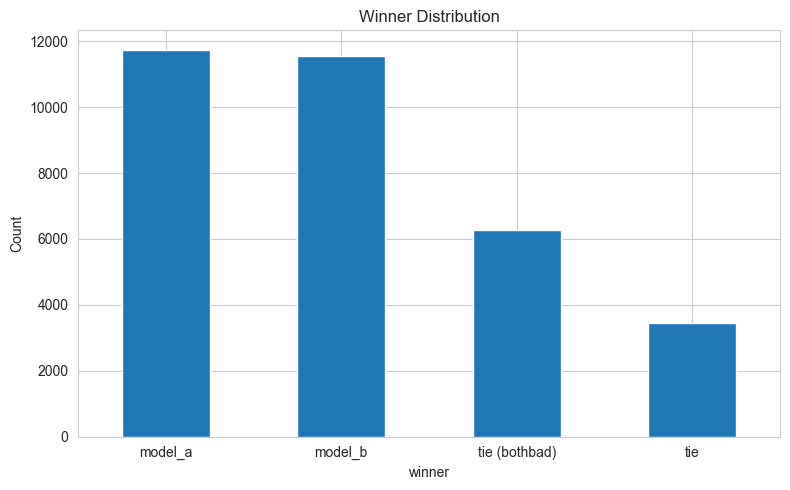

In [5]:
winner_counts = battles['winner'].value_counts()
print(winner_counts)

fig, ax = plt.subplots(figsize=(8, 5))
winner_counts.plot(kind='bar', ax=ax)
ax.set_title('Winner Distribution')
ax.set_ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()

## 4. Model Distribution

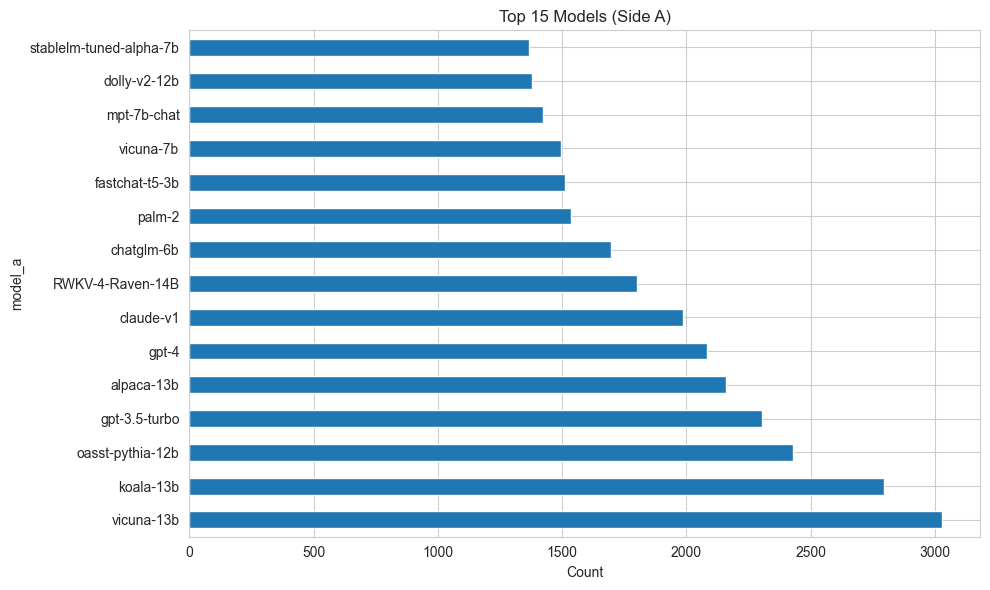

In [6]:
# Most common models
model_counts = battles['model_a'].value_counts().head(15)

fig, ax = plt.subplots(figsize=(10, 6))
model_counts.plot(kind='barh', ax=ax)
ax.set_title('Top 15 Models (Side A)')
ax.set_xlabel('Count')
plt.tight_layout()

## 5. Response Length Distribution

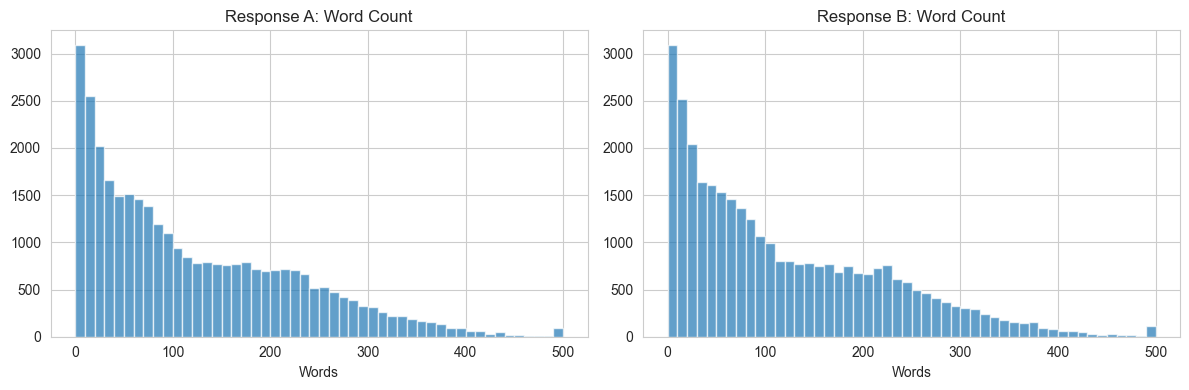

In [7]:
from quant_syco.features.lexical import compute_response_length_features

battles_with_length = compute_response_length_features(battles)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(battles_with_length['assistant_a_word_count'].clip(0, 500), bins=50, alpha=0.7)
axes[0].set_title('Response A: Word Count')
axes[0].set_xlabel('Words')

axes[1].hist(battles_with_length['assistant_b_word_count'].clip(0, 500), bins=50, alpha=0.7)
axes[1].set_title('Response B: Word Count')
axes[1].set_xlabel('Words')

plt.tight_layout()

## 6. Topic Distribution

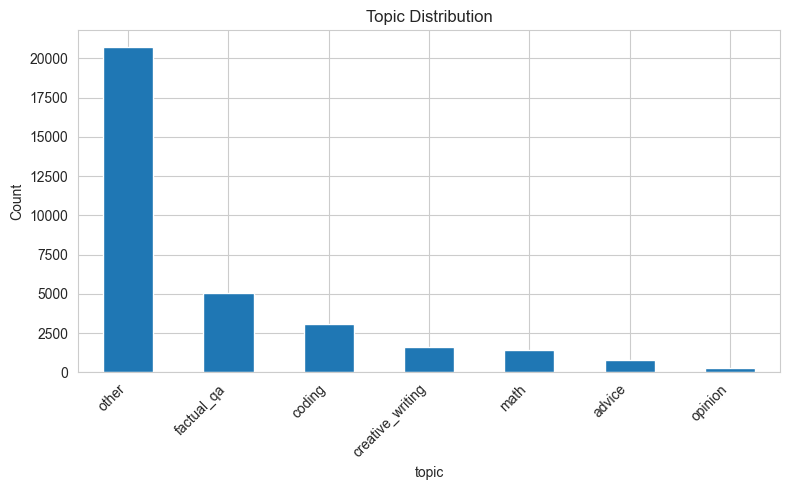

In [8]:
from quant_syco.features.topics import compute_topic_features, get_topic_distribution

battles_with_topics = compute_topic_features(battles)
topic_dist = get_topic_distribution(battles_with_topics)

fig, ax = plt.subplots(figsize=(8, 5))
topic_dist.plot(kind='bar', ax=ax)
ax.set_title('Topic Distribution')
ax.set_ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

## 7. Lexical Sycophancy Signals (Heuristic)

In [9]:
from quant_syco.features.lexical import compute_lexical_features

battles_lex = compute_lexical_features(battles, 'assistant_a')

print("Lexical sycophancy signals in assistant_a responses:")
for col in ['lex_flattery_count', 'lex_validation_seeking_count', 'lex_agreement_count']:
    if col in battles_lex.columns:
        print(f"  {col}: mean={battles_lex[col].mean():.2f}, max={battles_lex[col].max()}")

print(f"\nResponses with any lexical sycophancy signal: {battles_lex['lex_sycophancy_any'].mean():.1%}")

Lexical sycophancy signals in assistant_a responses:
  lex_flattery_count: mean=0.00, max=9
  lex_validation_seeking_count: mean=0.02, max=2
  lex_agreement_count: mean=0.00, max=2

Responses with any lexical sycophancy signal: 5.5%


## 8. Sample Conversations

In [10]:
# Show a few examples
sample = battles.sample(3, random_state=42)

for i, (_, row) in enumerate(sample.iterrows()):
    print(f"=== Example {i+1} ===")
    print(f"Winner: {row['winner']}")
    print(f"Model A: {row['model_a']} | Model B: {row['model_b']}")
    print(f"\nUser: {row['user_prompt'][:300]}...")
    print(f"\nAssistant A: {str(row['assistant_a'])[:300]}...")
    print(f"\nAssistant B: {str(row['assistant_b'])[:300]}...")
    print("\n")

=== Example 1 ===
Winner: model_b
Model A: oasst-pythia-12b | Model B: gpt-3.5-turbo

User: write me a weeding speech in Albanian...

Assistant A: Here it is:

"Albana, the land of the Albanians,

Our fields and forests, our mountains and seas,

Are filled with weeds that grow in abundance.

They take the nutrients from the soil,

Leaving behind only exhaustion and disappointment.

We must work together to root out these weeds,

So that our fi...

Assistant B: Përshëndetje të gjithëve,

Sot jemi të bashkuar për të festuar një moment të veçantë në jetën e dy njerëzve që e kanë gjetur dashurinë e tyre. Është e rëndësishme të jemi sot bashkë për të festuar dhe ndarë gëzimin e kësaj dite me ta.

Unë kam një fjalë të shkurtër për të dhënë sot. Ju, të dashurit ...


=== Example 2 ===
Winner: model_a
Model A: palm-2 | Model B: RWKV-4-Raven-14B

User: ISO 26262: technical requiremen for functional requirement "Thermocontrol System shall avoid sending false data regarding interior temperature t

## Next Steps

1. Run sycophancy labeling: `make label`
2. Continue with `02_labeling_validation.ipynb`